In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [2]:
DROP_COLS = {
    'data_location_id',
    'quality_automatic_check',
    'quality_manual_check',
    'id_global',
    'id_local'
}

SEGMENTS = pd.DataFrame({
    'device_id': [1143, 1145, 73223, 73224, 73225, 75176],
    'length':    [24,   200,   76,     116,    116,    76],
    'lanes':     [2,    2,     1,      1,      1,      1]
})

traffico = (
    pd.read_csv(
        './polito_sensors_vittorio/polito_sensors_vittorio_data.csv',
        index_col=0,
        usecols=lambda col: col not in DROP_COLS  # skip unwanted cols
    )
    .merge(SEGMENTS, on='device_id', how='left')
)

In [3]:
meteo = pd.read_csv('./meteo/history_2024.csv', index_col=0)
meteo.index = pd.to_datetime(meteo.index)
meteo = meteo.resample('D').mean()
rainy_dates = meteo[meteo['precipTotal'] > 0.0].index.normalize().date

In [4]:
t_extend = (
    traffico.copy()
    # 1) Datetime e colonne base
    .assign(
        timestamp_record=lambda d: pd.to_datetime(d['timestamp_record']),
        data=lambda d: d['timestamp_record'].dt.date,
        hour=lambda d: d['timestamp_record'].dt.hour,
        week=lambda d: d['timestamp_record'].dt.weekday + 1,
        month=lambda d: d['timestamp_record'].dt.month,
        rain=lambda d: d['timestamp_record'].dt.date.isin(rainy_dates).astype(int)
    )
    # 2) Categorie numeriche
    .assign(
        working_day=lambda d: d['week'].between(1, 5).astype(int),
        season=lambda d: d['month'].map({
            12: 0, 1: 0, 2: 0,        # Inverno
            3: 1, 4: 1, 5: 1,         # Primavera
            6: 2, 7: 2, 8: 2,         # Estate
            9: 3, 10: 3, 11: 3        # Autunno
        }),
        part_of_day=lambda d: np.select(
            [
                d['hour'].between(0, 5),
                d['hour'].between(6, 11),
                d['hour'].between(12, 17),
                d['hour'].between(18, 23)
            ],
            [0,  # night
             1,  # morning
             2,  # afternoon 
             3   # evening
            ],
            default=np.nan
        )
    )
    # 3) Filtro accuracy e drop
    .query('accuracy > 60')
    .drop(columns=['timestamp_record', 'key', 'data', 'accuracy'])
    .rename(columns={'value': 'count'})
)

t_extend

,device_id,count,length,lanes,hour,week,month,rain,working_day,season,part_of_day
0,73224,61.0,116,1,22,7,3,0,0,1,3.0
1,1143,116.0,24,2,22,7,3,0,0,1,3.0
2,73223,53.0,76,1,22,7,3,0,0,1,3.0
3,73225,116.0,116,1,22,7,3,0,0,1,3.0
4,1145,217.0,200,2,22,7,3,0,0,1,3.0
...,...,...,...,...,...,...,...,...,...,...,...
44865,73223,469.0,76,1,21,6,8,0,0,2,3.0
44866,1143,322.0,24,2,21,6,8,0,0,2,3.0
44867,73224,434.0,116,1,21,6,8,0,0,2,3.0
44868,1145,80.0,200,2,21,6,8,0,0,2,3.0


In [5]:
stats_extend = (
    t_extend
    .groupby(['lanes', 'hour', 'week', 'month', 'rain'], as_index=False)
    .agg(
        mean=('count', 'mean'),
        std=('count', 'std')
    )
)
stats_extend

,lanes,hour,week,month,rain,mean,std
0,1,0,1,1,0,109.125000,65.705919
1,1,0,1,4,0,41.625000,9.992497
2,1,0,1,5,0,41.384615,9.622356
3,1,0,1,6,0,52.812500,20.484852
4,1,0,1,7,0,61.866667,25.289373
...,...,...,...,...,...,...,...
4206,2,23,7,9,0,74.600000,19.693202
4207,2,23,7,10,0,80.500000,4.949747
4208,2,23,7,10,1,100.500000,47.752836
4209,2,23,7,11,0,126.375000,35.278231


In [6]:
pivot_mean_extend = (
    stats_extend
    .pivot_table(index=['lanes', 'hour', 'week', 'month'], columns='rain', values='mean')
    .rename(columns={0: 'clear_mean', 1: 'rain_mean'})
    .reset_index()
)
pivot_std_extend = (
    stats_extend
    .pivot_table(index=['lanes', 'hour', 'week', 'month'], columns='rain', values='std')
    .rename(columns={0: 'clear_std', 1: 'rain_std'})
    .reset_index()
)

pivot_extend = (
    pivot_mean_extend
    .merge(pivot_std_extend, on=['lanes', 'hour', 'week', 'month'], how='left')
    .rename_axis(columns=None)
)
pivot_extend

,lanes,hour,week,month,clear_mean,rain_mean,clear_std,rain_std
0,1,0,1,1,109.125000,NaN,65.705919,NaN
1,1,0,1,4,41.625000,NaN,9.992497,NaN
2,1,0,1,5,41.384615,NaN,9.622356,NaN
3,1,0,1,6,52.812500,NaN,20.484852,NaN
4,1,0,1,7,61.866667,NaN,25.289373,NaN
...,...,...,...,...,...,...,...,...
3693,2,23,7,8,31.750000,NaN,17.693825,NaN
3694,2,23,7,9,74.600000,NaN,19.693202,NaN
3695,2,23,7,10,80.500000,100.5,4.949747,47.752836
3696,2,23,7,11,126.375000,NaN,35.278231,NaN


In [7]:
nan_rain_condition = pivot_extend['rain_mean'].isna()
nan_rain = pivot_extend[nan_rain_condition]
missing_percent = nan_rain_condition.mean() * 100
print(missing_percent)
missing_by_hour = nan_rain['hour'].value_counts().sort_index()
missing_by_week = nan_rain['week'].value_counts().sort_index()
missing_by_month = nan_rain['month'].value_counts().sort_index()
print(missing_by_hour)
print(missing_by_week)
print(missing_by_month)

86.07355327203894
hour
0     132
1     132
2     132
3     132
4     133
5     132
6     132
7     132
8     132
9     132
10    132
11    132
12    132
13    132
14    132
15    134
16    133
17    133
18    133
19    135
20    133
21    133
22    134
23    134
Name: count, dtype: int64
week
1    481
2    441
3    480
4    433
5    386
6    480
7    482
Name: count, dtype: int64
month
1     336
2     168
3     170
4     336
5     336
6     336
7     336
8     336
9     289
10      2
11    242
12    296
Name: count, dtype: int64


### Aggregation per season, working days and part of the day

In [8]:
agg = (
    t_extend
    .groupby(['lanes', 'part_of_day', 'working_day', 'season', 'rain'], as_index=False)
    .agg(
        mean=('count', 'mean'),
        std=('count', 'std')
    )
)
agg

,lanes,part_of_day,working_day,season,rain,mean,std
0,1,0.0,0,0,0,166.942982,99.270029
1,1,0.0,0,1,0,236.453333,152.676723
2,1,0.0,0,2,0,172.882466,116.647903
3,1,0.0,0,3,0,174.009709,92.888863
4,1,0.0,0,3,1,131.404762,76.116425
...,...,...,...,...,...,...,...
82,2,3.0,1,0,1,328.583333,121.577853
83,2,3.0,1,1,0,277.342172,129.371691
84,2,3.0,1,2,0,200.880577,120.471523
85,2,3.0,1,3,0,283.112069,130.422084


In [9]:
pivot_mean_agg = (
    agg
    .pivot_table(index=['lanes', 'part_of_day', 'working_day', 'season'], columns='rain', values='mean')
    .rename(columns={0: 'clear_mean', 1: 'rain_mean'})
    .reset_index()
)
pivot_std_agg = (
    agg
    .pivot_table(index=['lanes', 'part_of_day', 'working_day', 'season'], columns='rain', values='std')
    .rename(columns={0: 'clear_std', 1: 'rain_std'})
    .reset_index()
)

pivot_agg = (
    pivot_mean_agg
    .merge(pivot_std_agg, on=['lanes', 'part_of_day', 'working_day', 'season'], how='left')
    .rename_axis(columns=None)
)
pivot_agg

,lanes,part_of_day,working_day,season,clear_mean,rain_mean,clear_std,rain_std
0,1,0.0,0,0,166.942982,NaN,99.270029,NaN
1,1,0.0,0,1,236.453333,NaN,152.676723,NaN
2,1,0.0,0,2,172.882466,NaN,116.647903,NaN
3,1,0.0,0,3,174.009709,131.404762,92.888863,76.116425
4,1,0.0,1,0,81.685969,48.090909,67.002544,33.824413
...,...,...,...,...,...,...,...,...
59,2,3.0,0,3,335.862500,342.304348,124.810860,129.851859
60,2,3.0,1,0,294.707366,328.583333,127.925938,121.577853
61,2,3.0,1,1,277.342172,NaN,129.371691,NaN
62,2,3.0,1,2,200.880577,NaN,120.471523,NaN


In [10]:
nan_rain_condition = pivot_agg['rain_mean'].isna()
nan_rain = pivot_agg[nan_rain_condition]
missing_percent = nan_rain_condition.mean() * 100
print(missing_percent)
missing_by_part_of_day = nan_rain['part_of_day'].value_counts().sort_index()
missing_by_working_day = nan_rain['working_day'].value_counts().sort_index()
missing_by_season = nan_rain['season'].value_counts().sort_index()
print(missing_by_part_of_day)
print(missing_by_working_day)
print(missing_by_season)

64.0625
part_of_day
0.0    10
1.0    10
2.0    10
3.0    11
Name: count, dtype: int64
working_day
0    24
1    17
Name: count, dtype: int64
season
0     9
1    16
2    16
Name: count, dtype: int64


## Fill NaNs

In [11]:
# 1) Aggiungo part_of_day, working_day e season in pivot_extend
pivot_extend_mapped = pivot_extend.assign(
    part_of_day=lambda df: np.select(
        [
            df['hour'].between(0, 5),
            df['hour'].between(6, 11),
            df['hour'].between(12, 17),
            df['hour'].between(18, 23),
        ],
        [0, 1, 2, 3],
        default=np.nan
    ).astype(int),
    working_day=lambda df: df['week'].between(1, 5).astype(int),
    season=lambda df: df['month'].map({
        12: 0, 1: 0, 2: 0,    # inverno
        3:  1, 4: 1, 5: 1,    # primavera
        6:  2, 7: 2, 8: 2,    # estate
        9:  3, 10:3, 11:3     # autunno
    })
)

# 2) Preparo pivot_agg rinominando le colonne di media e std
pivot_agg_renamed = pivot_agg.rename(columns={
    'clear_mean': 'clear_mean_agg',
    'rain_mean':  'rain_mean_agg',
    'clear_std':  'clear_std_agg',
    'rain_std':   'rain_std_agg'
})

# 3) Faccio il merge
merged = pivot_extend_mapped.merge(
    pivot_agg_renamed,
    on=['lanes', 'part_of_day', 'working_day', 'season'],
    how='left'
)

# Se vuoi, poi puoi rimuovere le colonne di mapping:
merged = merged.drop(columns=['part_of_day', 'working_day', 'season'])

print(merged)

      lanes  hour  week  month  clear_mean  rain_mean  clear_std   rain_std  \
0         1     0     1      1  109.125000        NaN  65.705919        NaN   
1         1     0     1      4   41.625000        NaN   9.992497        NaN   
2         1     0     1      5   41.384615        NaN   9.622356        NaN   
3         1     0     1      6   52.812500        NaN  20.484852        NaN   
4         1     0     1      7   61.866667        NaN  25.289373        NaN   
...     ...   ...   ...    ...         ...        ...        ...        ...   
3693      2    23     7      8   31.750000        NaN  17.693825        NaN   
3694      2    23     7      9   74.600000        NaN  19.693202        NaN   
3695      2    23     7     10   80.500000      100.5   4.949747  47.752836   
3696      2    23     7     11  126.375000        NaN  35.278231        NaN   
3697      2    23     7     12  162.750000        NaN  66.709853        NaN   

      clear_mean_agg  rain_mean_agg  clear_std_agg 

In [12]:
merged_copy = merged.copy()

# Mappa i mesi alle stagioni
merged_copy['season'] = merged_copy['month'].map({
    12: 'winter', 1: 'winter', 2: 'winter',
    3: 'spring', 4: 'spring', 5: 'spring',
    6: 'summer', 7: 'summer', 8: 'summer',
    9: 'autumn', 10: 'autumn', 11: 'autumn'
})

# Colonne da riempire
columns_to_fill = ['clear_mean', 'clear_std', 'rain_mean', 'rain_std', 'rain_mean_agg', 'rain_std_agg']

# Riempimento NaN per ogni colonna
for col in columns_to_fill:
    nan_indices = merged_copy[merged_copy[col].isna()].index

    for idx in nan_indices:
        row = merged_copy.loc[idx]

        same_group = merged_copy[
            (merged_copy['lanes'] == row['lanes']) &
            (merged_copy['hour'] == row['hour']) &
            (merged_copy['week'] == row['week']) &
            (merged_copy['season'] == row['season']) &
            (merged_copy[col].notna())
        ]

        if not same_group.empty:
            merged_copy.at[idx, col] = same_group[col].mean()

print(merged_copy[columns_to_fill].isna().sum())

clear_mean          0
clear_std           0
rain_mean        2592
rain_std         2785
rain_mean_agg    2150
rain_std_agg     2150
dtype: int64


In [13]:
na_counts_by_month = merged_copy.groupby('month')[
    ['clear_mean', 'clear_std', 'rain_mean', 'rain_std', 'rain_mean_agg', 'rain_std_agg']
].apply(lambda x: x.isna().sum())

print(na_counts_by_month)

       clear_mean  clear_std  rain_mean  rain_std  rain_mean_agg  rain_std_agg
month                                                                         
1               0          0        296       299            126           126
2               0          0        144       145             48            48
3               0          0        170       170            170           170
4               0          0        336       336            336           336
5               0          0        336       336            336           336
6               0          0        336       336            336           336
7               0          0        336       336            336           336
8               0          0        336       336            336           336
9               0          0          2        64              0             0
10              0          0          2        64              0             0
11              0          0          2        64   

### Random Forest

In [14]:
print(merged_copy)

      lanes  hour  week  month  clear_mean  rain_mean  clear_std   rain_std  \
0         1     0     1      1  109.125000        NaN  65.705919        NaN   
1         1     0     1      4   41.625000        NaN   9.992497        NaN   
2         1     0     1      5   41.384615        NaN   9.622356        NaN   
3         1     0     1      6   52.812500        NaN  20.484852        NaN   
4         1     0     1      7   61.866667        NaN  25.289373        NaN   
...     ...   ...   ...    ...         ...        ...        ...        ...   
3693      2    23     7      8   31.750000        NaN  17.693825        NaN   
3694      2    23     7      9   74.600000      100.5  19.693202  47.752836   
3695      2    23     7     10   80.500000      100.5   4.949747  47.752836   
3696      2    23     7     11  126.375000      100.5  35.278231  47.752836   
3697      2    23     7     12  162.750000        NaN  66.709853        NaN   

      clear_mean_agg  rain_mean_agg  clear_std_agg 

In [15]:
# --- 1) Partiamo dal DataFrame già unito ---
df = merged_copy.copy()

# --- 2) Preprocessing: ciclico e one-hot ---
def cyclical_time_features(df):
    return np.vstack([
        np.sin(2 * np.pi * df['hour']  / 24),
        np.cos(2 * np.pi * df['hour']  / 24),
        np.sin(2 * np.pi * df['month'] / 12),
        np.cos(2 * np.pi * df['month'] / 12),
    ]).T

time_cyc = FunctionTransformer(
    cyclical_time_features,
    feature_names_out=lambda names: ['hour_sin','hour_cos','month_sin','month_cos']
)

cat_enc = OneHotEncoder(drop='if_binary', sparse_output=False)

preprocessor = ColumnTransformer([
    ('time', time_cyc,    ['hour','month']),
    ('cat',  cat_enc,     ['lanes','week']),
    ('num',  'passthrough', [
        'clear_mean','clear_std',
        'clear_mean_agg','clear_std_agg',
        'rain_mean_agg','rain_std_agg',
        'rain_std'
    ])
], remainder='drop')

# --- 3) Costruisco X e y includendo tutte le colonne ---
X_all = df[[
    'hour','month','lanes','week',
    'clear_mean','clear_std',
    'clear_mean_agg','clear_std_agg',
    'rain_mean_agg','rain_std_agg',
    'rain_std'
]]
y_all = df['rain_mean']

mask_known = y_all.notna()
X_known = X_all[mask_known]
y_known = y_all[mask_known]
X_miss  = X_all[~mask_known]

# --- 4) Pipeline per preprocessing + regressore ---
pipeline = Pipeline([
    ('prep', preprocessor),
    ('rf',   RandomForestRegressor(n_estimators=100, random_state=42))
])

# --- 5) Cross-validation sull’imputazione ---
scores = cross_val_score(
    pipeline,
    X_known,
    y_known,
    cv=5,
    scoring='neg_mean_squared_error'
)
rmse = np.sqrt(-scores)
print("CV RMSE per imputazione di rain_mean:", rmse, "=> mean:", rmse.mean())

# --- 7) Fit su tutto il noto e predict sui missing ---
pipeline.fit(X_known, y_known)
y_pred = pipeline.predict(X_miss)
df.loc[~mask_known, 'rain_mean_imp'] = y_pred

CV RMSE per imputazione di rain_mean: [68.63106452 61.78461064 58.02085926 68.05226366 61.64070157] => mean: 63.62589993025173


In [16]:
# --- 8) Analisi importanze features incluse ---
# nomi feature cicliche
time_names = ['hour_sin','hour_cos','month_sin','month_cos']
# nomi one-hot
cat = pipeline.named_steps['prep'].named_transformers_['cat']
cat_names = cat.get_feature_names_out(['lanes','week'])
# nomi passthrough numerici
num_names = [
    'clear_mean','clear_std',
    'clear_mean_agg','clear_std_agg',
    'rain_mean_agg','rain_std_agg', 'rain_std'
]
# concateno e mostro importanze
feat_names = np.concatenate([time_names, cat_names, num_names])
importances = pipeline.named_steps['rf'].feature_importances_
for name, imp in sorted(zip(feat_names, importances), key=lambda x: -x[1]):
    print(f"{name:20s} -> {imp:.3f}")

clear_mean           -> 0.877
clear_mean_agg       -> 0.030
rain_mean_agg        -> 0.029
rain_std             -> 0.020
hour_cos             -> 0.015
clear_std            -> 0.009
hour_sin             -> 0.005
rain_std_agg         -> 0.003
clear_std_agg        -> 0.003
week_4               -> 0.002
week_6               -> 0.001
week_2               -> 0.001
week_5               -> 0.001
month_sin            -> 0.001
month_cos            -> 0.001
week_7               -> 0.001
week_3               -> 0.001
week_1               -> 0.001
lanes_2              -> 0.000


In [17]:
# --- 1) Target per la regressione di rain_std ---
y_std_all = df['rain_std']

mask_known_std = y_std_all.notna()
X_known_std = X_all[mask_known_std]
y_known_std = y_std_all[mask_known_std]
X_miss_std  = X_all[~mask_known_std]

# --- 2) Pipeline per imputazione di rain_std ---
pipeline_std = Pipeline([
    ('prep', preprocessor),
    ('rf',   RandomForestRegressor(n_estimators=100, random_state=42))
])

# --- 3) Valutazione della regressione su rain_std ---
scores_std = cross_val_score(
    pipeline_std,
    X_known_std,
    y_known_std,
    cv=5,
    scoring='neg_mean_squared_error'
)
rmse_std = np.sqrt(-scores_std)
print("CV RMSE per imputazione di rain_std:", rmse_std, "=> mean:", rmse_std.mean())

# --- 4) Fit su tutto il noto e predict sui missing ---
pipeline_std.fit(X_known_std, y_known_std)
y_pred_std = pipeline_std.predict(X_miss_std)
df.loc[~mask_known_std, 'rain_std_imp'] = y_pred_std

CV RMSE per imputazione di rain_std: [1.38930886 1.5349507  0.81097553 6.53952964 0.36261691] => mean: 2.1274763266292025


In [18]:
print(df)

      lanes  hour  week  month  clear_mean  rain_mean  clear_std   rain_std  \
0         1     0     1      1  109.125000        NaN  65.705919        NaN   
1         1     0     1      4   41.625000        NaN   9.992497        NaN   
2         1     0     1      5   41.384615        NaN   9.622356        NaN   
3         1     0     1      6   52.812500        NaN  20.484852        NaN   
4         1     0     1      7   61.866667        NaN  25.289373        NaN   
...     ...   ...   ...    ...         ...        ...        ...        ...   
3693      2    23     7      8   31.750000        NaN  17.693825        NaN   
3694      2    23     7      9   74.600000      100.5  19.693202  47.752836   
3695      2    23     7     10   80.500000      100.5   4.949747  47.752836   
3696      2    23     7     11  126.375000      100.5  35.278231  47.752836   
3697      2    23     7     12  162.750000        NaN  66.709853        NaN   

      clear_mean_agg  rain_mean_agg  clear_std_agg 

## Check Regressed Values

In [19]:
df_final = (
    df.copy()
    .assign(
        rain_mean=lambda d: d['rain_mean'].fillna(d['rain_mean_imp']),
        rain_std=lambda d: d['rain_std'].fillna(d['rain_std_imp']),
    )
    .drop(columns=[
        'rain_mean_imp', 'rain_std_imp',
        'rain_mean_agg', 'rain_std_agg',
        'clear_mean_agg', 'clear_std_agg',
        'season'
    ]
)
)

print(df_final)

      lanes  hour  week  month  clear_mean   rain_mean  clear_std   rain_std
0         1     0     1      1  109.125000   95.651875  65.705919  34.233224
1         1     0     1      4   41.625000   32.961875   9.992497  34.222670
2         1     0     1      5   41.384615   32.301875   9.622356  34.222670
3         1     0     1      6   52.812500   43.307917  20.484852  34.227638
4         1     0     1      7   61.866667   50.286042  25.289373  34.225878
...     ...   ...   ...    ...         ...         ...        ...        ...
3693      2    23     7      8   31.750000   31.621905  17.693825  34.186460
3694      2    23     7      9   74.600000  100.500000  19.693202  47.752836
3695      2    23     7     10   80.500000  100.500000   4.949747  47.752836
3696      2    23     7     11  126.375000  100.500000  35.278231  47.752836
3697      2    23     7     12  162.750000  133.280833  66.709853  34.154146

[3698 rows x 8 columns]


In [20]:
df_final['clear_cv'] = df_final['clear_std'] / df_final['clear_mean']
df_final['rain_cv'] = df_final['rain_std'] / df_final['rain_mean']
print(df_final)

      lanes  hour  week  month  clear_mean   rain_mean  clear_std   rain_std  \
0         1     0     1      1  109.125000   95.651875  65.705919  34.233224   
1         1     0     1      4   41.625000   32.961875   9.992497  34.222670   
2         1     0     1      5   41.384615   32.301875   9.622356  34.222670   
3         1     0     1      6   52.812500   43.307917  20.484852  34.227638   
4         1     0     1      7   61.866667   50.286042  25.289373  34.225878   
...     ...   ...   ...    ...         ...         ...        ...        ...   
3693      2    23     7      8   31.750000   31.621905  17.693825  34.186460   
3694      2    23     7      9   74.600000  100.500000  19.693202  47.752836   
3695      2    23     7     10   80.500000  100.500000   4.949747  47.752836   
3696      2    23     7     11  126.375000  100.500000  35.278231  47.752836   
3697      2    23     7     12  162.750000  133.280833  66.709853  34.154146   

      clear_cv   rain_cv  
0     0.6021

In [21]:
print(df_final.isna().any())

lanes         False
hour          False
week          False
month         False
clear_mean    False
rain_mean     False
clear_std     False
rain_std      False
clear_cv      False
rain_cv       False
dtype: bool


In [22]:
grid = (
    pd.MultiIndex
      .from_product([[1, 2], list(range(24)), list(range(1, 8)), list(range(1, 13))],
                    names=['lanes','hour','week','month'])
      .to_frame(index=False)
)
combo_with_delta = (
    df_final
    .loc[df_final['rain_mean'].notna(), ['lanes', 'hour', 'week', 'month']]
    .drop_duplicates()
)
missing_combos = (
    grid
    .merge(combo_with_delta, on=['lanes', 'hour', 'week', 'month'], how='left', indicator=True)
    .query('_merge == "left_only"')
    .drop(columns=['_merge'])
)
pattern_summary = (
    missing_combos
    .groupby('month')
    .size()
    .reset_index(name='missing_count')
    .sort_values('missing_count', ascending=False)
)
pattern_summary

,month,missing_count
0,2,168
1,3,166


In [23]:
df_complete = grid.merge(df_final, on=['lanes', 'hour', 'week', 'month'], how='left')

df_complete['season'] = df_complete['month'].map({
    12: 'winter', 1: 'winter', 2: 'winter',
    3: 'spring', 4: 'spring', 5: 'spring',
    6: 'summer', 7: 'summer', 8: 'summer',
    9: 'autumn', 10: 'autumn', 11: 'autumn'
})

columns_to_fill = ['clear_mean', 'rain_mean', 'clear_std', 'rain_std', 'clear_cv', 'rain_cv']

for col in columns_to_fill:
    nan_indices = df_complete[df_complete[col].isna()].index

    for idx in nan_indices:
        row = df_complete.loc[idx]

        same_group = df_complete[
            (df_complete['lanes'] == row['lanes']) &
            (df_complete['hour'] == row['hour']) &
            (df_complete['week'] == row['week']) &
            (df_complete['season'] == row['season']) &
            (df_complete[col].notna())
        ]

        if not same_group.empty:
            df_complete.at[idx, col] = same_group[col].mean()
            
df_complete.drop(columns='season', inplace=True)
print("Rimane qualche NaN?", df_complete.isna().any().any())

Rimane qualche NaN? False


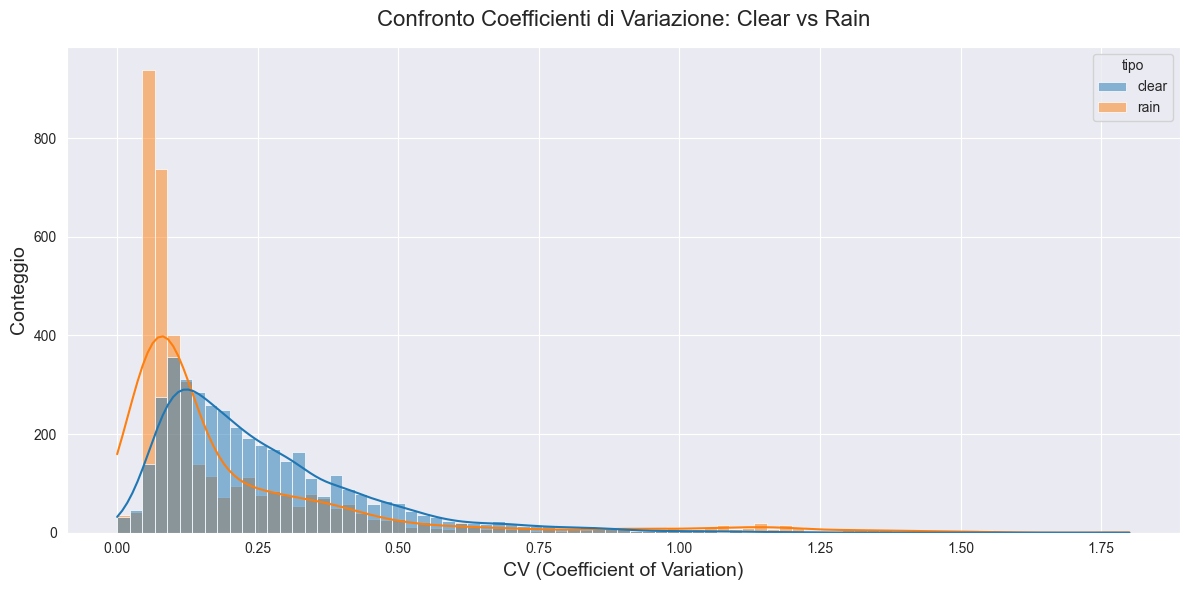

In [24]:
df_cv = pd.DataFrame({
    'cv': pd.concat([df_complete['clear_cv'], df_complete['rain_cv']]),
    'tipo': ['clear'] * len(df_complete) + ['rain'] * len(df_complete)
})

plt.figure(figsize=(12, 6))
sns.histplot(
    data=df_cv,
    x="cv",
    hue="tipo",
    stat="count",
    kde=True,
    alpha=0.5,
    edgecolor="white",
    linewidth=0.5
)
plt.title("Confronto Coefficienti di Variazione: Clear vs Rain", fontsize=16, pad=15)
plt.xlabel("CV (Coefficient of Variation)", fontsize=14)
plt.ylabel("Conteggio", fontsize=14)
plt.tight_layout()
plt.show()

In [25]:
percentiles = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
clear_cv_percentiles = df_complete['clear_cv'].quantile(percentiles)
rain_cv_percentiles = df_complete['rain_cv'].quantile(percentiles)
cv_percentiles = pd.concat([clear_cv_percentiles, rain_cv_percentiles], axis=1)
print(cv_percentiles)

      clear_cv   rain_cv
0.01  0.031080  0.026595
0.05  0.065210  0.050057
0.10  0.083418  0.051293
0.25  0.123299  0.066554
0.50  0.206455  0.100216
0.75  0.334898  0.252030
0.90  0.498548  0.485706
0.95  0.631451  0.903607
0.99  0.904966  1.318068


## Calculate Penalty and Seasonality

### `seasonality`

Represents the **seasonal variation** in average traffic speed under clear-sky conditions.

It compares the `clear_mean` for a given `(hour, month, lanes)` to its **baseline value in November**, then smooths the result using a `tanh` transformation to keep values within ±100%.

- `0%` → current traffic is consistent with November  
- `+X%` → traffic is **faster than in November** under clear skies  
- `−X%` → traffic is **slower than in November** under clear skies  

This metric captures **recurring seasonal effects** such as holidays, school periods, daylight differences, or typical weather trends.

---

### `delta`

Measures the **impact of rain on traffic speed**, comparing average speed during rain (`rain_mean`) with clear conditions (`clear_mean`) for the same `(hour, week, month, lanes)` combination.

The result is normalized using a `tanh` transformation to constrain values between −100% and +100%.

- `0%` → no difference between rain and clear  
- `+X%` → traffic is **faster in rain** (unusual, may indicate anomalies or noise)  
- `−X%` → traffic is **slower in rain**, indicating weather-related delays  

This value is used as a **weather penalty factor** in downstream models to simulate or predict performance degradation under rain conditions.


In [26]:
print(df_complete)

      lanes  hour  week  month  clear_mean   rain_mean  clear_std   rain_std  \
0         1     0     1      1  109.125000   95.651875  65.705919  34.233224   
1         1     0     1      2  110.244318   95.221875  60.196398  34.235719   
2         1     0     1      3   41.504808   32.631875   9.807427  34.222670   
3         1     0     1      4   41.625000   32.961875   9.992497  34.222670   
4         1     0     1      5   41.384615   32.301875   9.622356  34.222670   
...     ...   ...   ...    ...         ...         ...        ...        ...   
4027      2    23     7      8   31.750000   31.621905  17.693825  34.186460   
4028      2    23     7      9   74.600000  100.500000  19.693202  47.752836   
4029      2    23     7     10   80.500000  100.500000   4.949747  47.752836   
4030      2    23     7     11  126.375000  100.500000  35.278231  47.752836   
4031      2    23     7     12  162.750000  133.280833  66.709853  34.154146   

      clear_cv   rain_cv  
0     0.6021

In [27]:
df_stats = df_complete.copy()

# Epsilon per stabilità numerica
eps = 1e-3

# Calcolo del delta basato SOLO sulle medie (senza pesi)
df_stats['delta_raw_mean'] = 100 * (df_stats['rain_mean'] - df_stats['clear_mean']) / (df_stats['clear_mean'] + eps)

# Smussamento con funzione tanh per contenere entro [-100, +100]
df_stats['delta_normalized'] = 100 * np.tanh(df_stats['delta_raw_mean'] / 100)

# Calcolo della media di novembre per 'clear_mean'
november_means = (
    df_stats[df_stats['month'] == 11]
    .groupby(['lanes', 'hour'])['clear_mean']
    .mean()
    .reset_index()
    .rename(columns={'clear_mean': 'clear_mean_nov'})
)

# Merge con df_stats
df_stats = df_stats.merge(november_means, on=['lanes', 'hour'], how='left')

# Calcolo della seasonality e smussamento con tanh
df_stats['seasonality_raw'] = 100 * (
    df_stats['clear_mean'] - df_stats['clear_mean_nov']
) / (df_stats['clear_mean_nov'] + eps)

# Clipping con tanh
df_stats['seasonality_normalized'] = 100 * np.tanh(df_stats['seasonality_raw'] / 100)

# Cleanup: elimina colonne intermedie se vuoi
df_stats.drop(columns=[
    'clear_mean_nov',
    'delta_raw_mean',
    'seasonality_raw'
], inplace=True)

print(df_stats)

      lanes  hour  week  month  clear_mean   rain_mean  clear_std   rain_std  \
0         1     0     1      1  109.125000   95.651875  65.705919  34.233224   
1         1     0     1      2  110.244318   95.221875  60.196398  34.235719   
2         1     0     1      3   41.504808   32.631875   9.807427  34.222670   
3         1     0     1      4   41.625000   32.961875   9.992497  34.222670   
4         1     0     1      5   41.384615   32.301875   9.622356  34.222670   
...     ...   ...   ...    ...         ...         ...        ...        ...   
4027      2    23     7      8   31.750000   31.621905  17.693825  34.186460   
4028      2    23     7      9   74.600000  100.500000  19.693202  47.752836   
4029      2    23     7     10   80.500000  100.500000   4.949747  47.752836   
4030      2    23     7     11  126.375000  100.500000  35.278231  47.752836   
4031      2    23     7     12  162.750000  133.280833  66.709853  34.154146   

      clear_cv   rain_cv  delta_normali

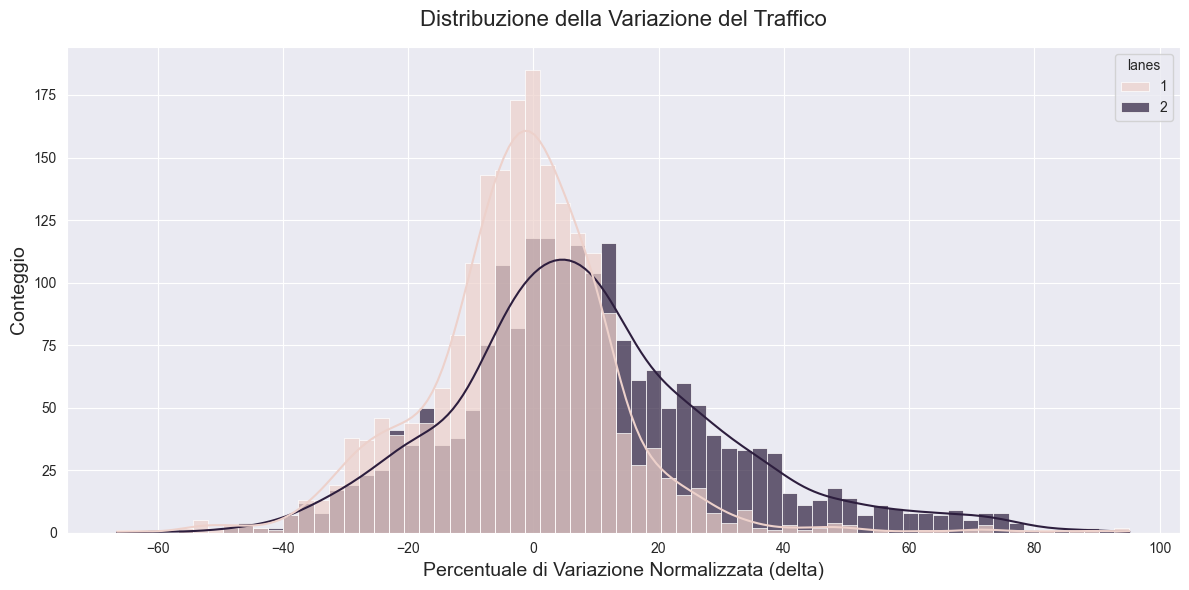

In [28]:
plt.figure(figsize=(12, 6))

sns.histplot(
    data=df_stats,
    x="delta_normalized",
    stat="count",
    alpha=0.7,
    edgecolor="white",
    linewidth=0.5,
    hue="lanes",
    multiple="layer",
    kde="True"
)

plt.title("Distribuzione della Variazione del Traffico", fontsize=16, pad=15)
plt.xlabel("Percentuale di Variazione Normalizzata (delta)", fontsize=14)
plt.ylabel("Conteggio", fontsize=14)
plt.tight_layout()
plt.show()

In [29]:
delta_normalized_percentiles = df_stats['delta_normalized'].quantile(percentiles)
print(delta_normalized_percentiles)

0.01   -38.222605
0.05   -27.304456
0.10   -20.377582
0.25    -7.593196
0.50     1.607498
0.75    11.764865
0.90    27.069868
0.95    39.063687
0.99    69.155112
Name: delta_normalized, dtype: float64


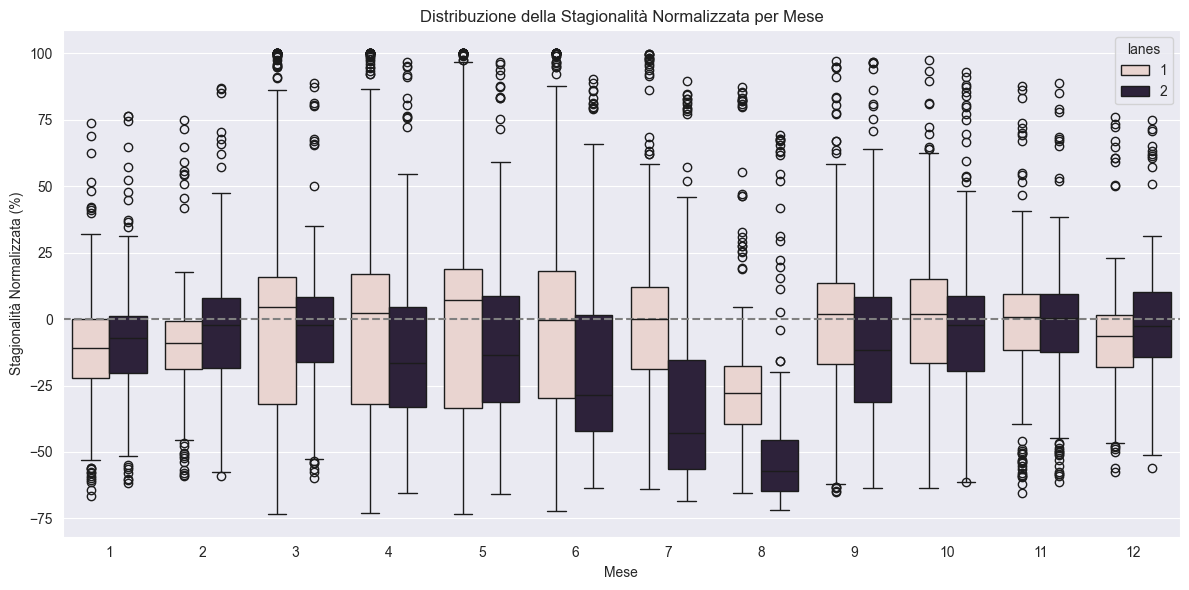

In [30]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_stats, x='month', y='seasonality_normalized', hue='lanes')
plt.axhline(0, color='gray', linestyle='--')
plt.title('Distribuzione della Stagionalità Normalizzata per Mese')
plt.xlabel('Mese')
plt.ylabel('Stagionalità Normalizzata (%)')
plt.tight_layout()
plt.show()

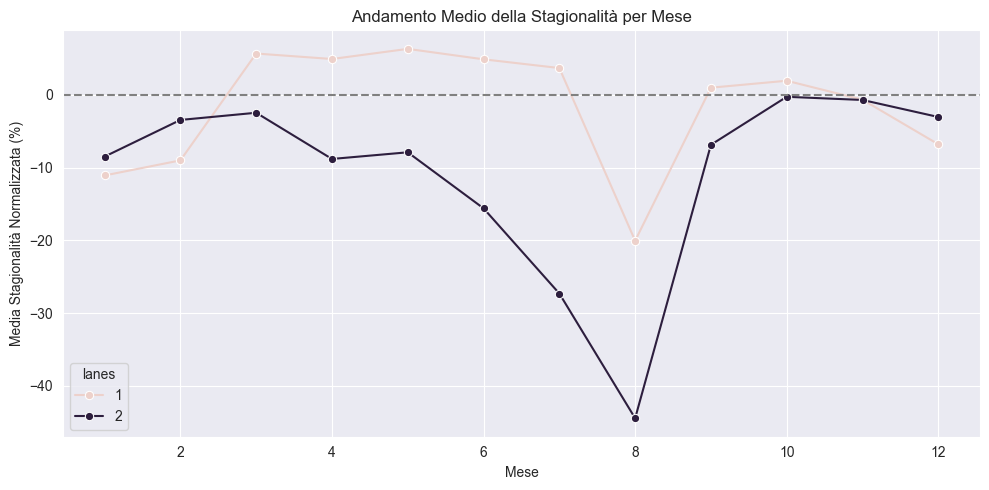

In [31]:
monthly_seasonality = (
    df_stats.groupby(['month', 'lanes'])['seasonality_normalized']
    .mean()
    .reset_index()
)

plt.figure(figsize=(10, 5))
sns.lineplot(data=monthly_seasonality, x='month', y='seasonality_normalized', hue='lanes', marker='o')
plt.axhline(0, color='gray', linestyle='--')
plt.title('Andamento Medio della Stagionalità per Mese')
plt.xlabel('Mese')
plt.ylabel('Media Stagionalità Normalizzata (%)')
plt.tight_layout()
plt.show()

In [32]:
df_stats['seasonality_normalized'].describe()

count    4032.000000
mean       -6.174408
std        37.783212
min       -73.242187
25%       -31.852398
50%        -7.085824
75%         9.134988
max        99.999963
Name: seasonality_normalized, dtype: float64

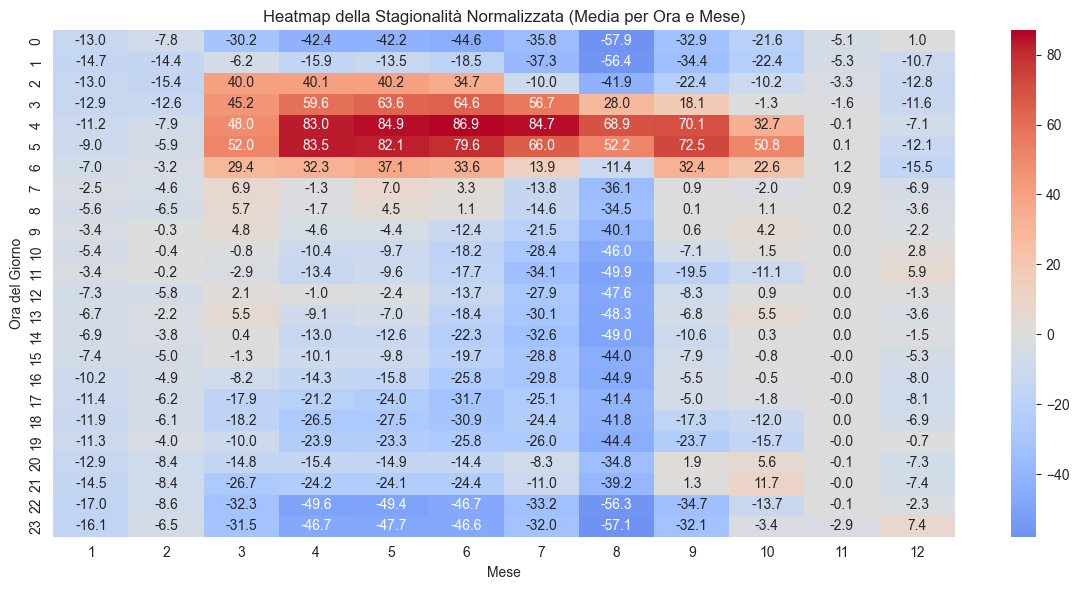

In [33]:
pivot = df_stats.pivot_table(
    values='seasonality_normalized',
    index='hour', columns='month',
    aggfunc='mean'
)

plt.figure(figsize=(12, 6))
sns.heatmap(pivot, annot=True, fmt=".1f", cmap='coolwarm', center=0)
plt.title('Heatmap della Stagionalità Normalizzata (Media per Ora e Mese)')
plt.xlabel('Mese')
plt.ylabel('Ora del Giorno')
plt.tight_layout()
plt.show()

In [34]:
print(df_stats.isna().any())

lanes                     False
hour                      False
week                      False
month                     False
clear_mean                False
rain_mean                 False
clear_std                 False
rain_std                  False
clear_cv                  False
rain_cv                   False
delta_normalized          False
seasonality_normalized    False
dtype: bool


## Extend to 3 and 4 lanes

In [35]:
print(df_stats)

      lanes  hour  week  month  clear_mean   rain_mean  clear_std   rain_std  \
0         1     0     1      1  109.125000   95.651875  65.705919  34.233224   
1         1     0     1      2  110.244318   95.221875  60.196398  34.235719   
2         1     0     1      3   41.504808   32.631875   9.807427  34.222670   
3         1     0     1      4   41.625000   32.961875   9.992497  34.222670   
4         1     0     1      5   41.384615   32.301875   9.622356  34.222670   
...     ...   ...   ...    ...         ...         ...        ...        ...   
4027      2    23     7      8   31.750000   31.621905  17.693825  34.186460   
4028      2    23     7      9   74.600000  100.500000  19.693202  47.752836   
4029      2    23     7     10   80.500000  100.500000   4.949747  47.752836   
4030      2    23     7     11  126.375000  100.500000  35.278231  47.752836   
4031      2    23     7     12  162.750000  133.280833  66.709853  34.154146   

      clear_cv   rain_cv  delta_normali

In [36]:
df_stats = df_stats.rename(columns={
    'delta_normalized': 'delta',
    'seasonality_normalized': 'seasonality'
})

lookup_delta = (
    df_stats[df_stats['lanes'].isin([1, 2])]
    .pivot_table(index=['hour', 'week', 'month'], columns='lanes', values='delta')
    .rename(columns={1: 'd1', 2: 'd2'})
    .reset_index()
)

lookup_seasonality = (
    df_stats[df_stats['lanes'].isin([1, 2])]
    .pivot_table(index=['hour', 'week', 'month'], columns='lanes', values='seasonality')
    .rename(columns={1: 's1', 2: 's2'})
    .reset_index()
)

# 3. Funzione generica per interpolare e smussare (tanh)
def interpolate_metric(lookup, col1, col2, lane_value, result_name):
    df = lookup.copy()
    df['lanes'] = lane_value
    df['alpha'] = df[col1]
    df['beta'] = (df[col2] - df[col1]) / np.log(2)
    df[result_name] = df['alpha'] + df['beta'] * np.log(lane_value)
    # Smussamento tanh entro [-100, +100]
    df[result_name] = 100 * np.tanh(df[result_name] / 100)
    return df[['lanes', 'hour', 'week', 'month', result_name]]

# 4. Applica interpolazione per lanes 3 e 4
delta_3 = interpolate_metric(lookup_delta, 'd1', 'd2', 3, 'delta')
delta_4 = interpolate_metric(lookup_delta, 'd1', 'd2', 4, 'delta')

season_3 = interpolate_metric(lookup_seasonality, 's1', 's2', 3, 'seasonality')
season_4 = interpolate_metric(lookup_seasonality, 's1', 's2', 4, 'seasonality')

# 5. Unisci penalità interpolate
penalties_3 = pd.merge(delta_3, season_3, on=['lanes', 'hour', 'week', 'month'])
penalties_4 = pd.merge(delta_4, season_4, on=['lanes', 'hour', 'week', 'month'])

# 6. Ricombina con dati originali (lanes 1 e 2 già calcolati)
df_extended = pd.concat([
    df_stats[df_stats['lanes'].isin([1, 2])][['lanes', 'hour', 'week', 'month', 'delta', 'seasonality']],
    penalties_3,
    penalties_4
], ignore_index=True).sort_values(by=['lanes', 'hour', 'week', 'month']).reset_index(drop=True)

# 7. Controllo finale
print("Righe totali:", len(df_extended))
print("Corsie uniche:", sorted(df_extended['lanes'].unique()))


Righe totali: 8064
Corsie uniche: [np.int64(1), np.int64(2), np.int64(3), np.int64(4)]


In [37]:
print(df_extended.isna().any())

lanes          False
hour           False
week           False
month          False
delta          False
seasonality    False
dtype: bool


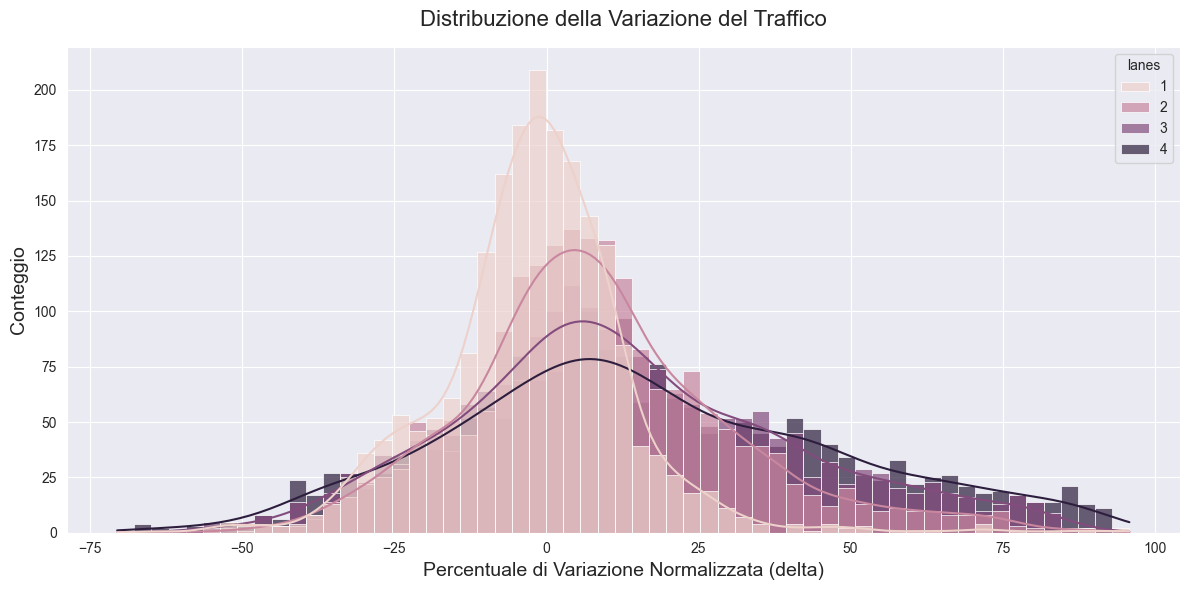

In [38]:
plt.figure(figsize=(12, 6))

sns.histplot(
    data=df_extended,
    x="delta",
    stat="count",
    alpha=0.7,
    edgecolor="white",
    linewidth=0.5,
    hue="lanes",
    multiple="layer",
    kde="True"
)

plt.title("Distribuzione della Variazione del Traffico", fontsize=16, pad=15)
plt.xlabel("Percentuale di Variazione Normalizzata (delta)", fontsize=14)
plt.ylabel("Conteggio", fontsize=14)
plt.tight_layout()
plt.show()

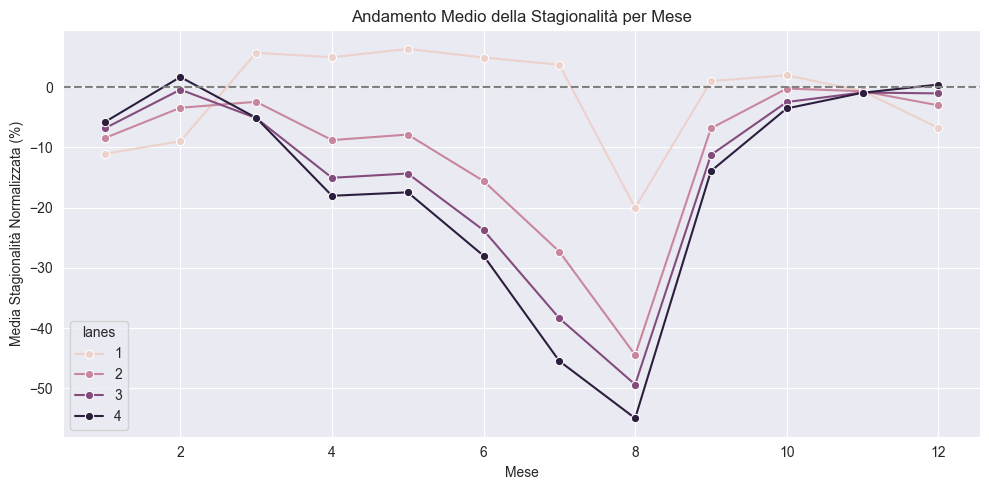

In [39]:
monthly_seasonality = (
    df_extended.groupby(['month', 'lanes'])['seasonality']
    .mean()
    .reset_index()
)

plt.figure(figsize=(10, 5))
sns.lineplot(data=monthly_seasonality, x='month', y='seasonality', hue='lanes', marker='o')
plt.axhline(0, color='gray', linestyle='--')
plt.title('Andamento Medio della Stagionalità per Mese')
plt.xlabel('Mese')
plt.ylabel('Media Stagionalità Normalizzata (%)')
plt.tight_layout()
plt.show()

## Check penalties

In [40]:
delta = df_extended.copy()
delta['delta'] = delta['delta'].clip(lower=-100, upper=100)
delta['delta'] = -1*delta['delta']/100
delta['seasonality'] = delta['seasonality']/100
delta.rename(columns={'delta': 'penalty', 'lanes': 'lane'}, inplace=True)
delta

,lane,hour,week,month,penalty,seasonality
0,1,0,1,1,0.122840,-0.315136
1,1,0,1,2,0.135427,-0.308898
2,1,0,1,3,0.210578,-0.631397
3,1,0,1,4,0.205165,-0.630951
4,1,0,1,5,0.216009,-0.631843
...,...,...,...,...,...,...
8059,4,23,7,8,-0.096573,-0.616533
8060,4,23,7,9,-0.366498,-0.480164
8061,4,23,7,10,-0.016421,-0.417189
8062,4,23,7,11,0.080684,-0.346589


In [41]:
delta.to_csv('penalties.csv')

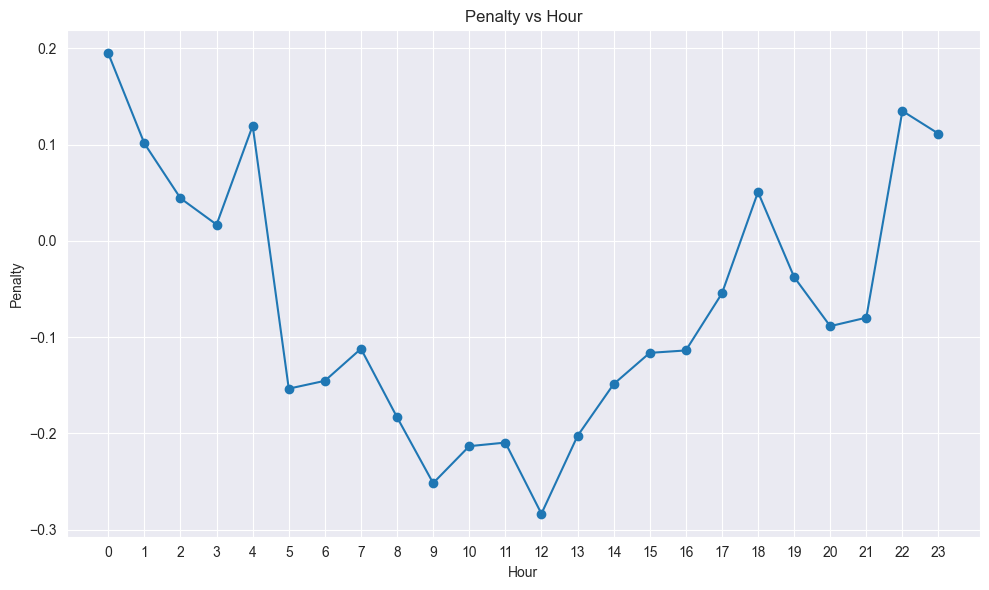

In [42]:
test = delta[(delta['month'] == 5) & (delta['week'] == 3) & (delta['lane'] == 2)]
plt.figure(figsize=(10, 6))
plt.plot(test['hour'], test['penalty'], marker='o', linestyle='-')
plt.title('Penalty vs Hour')
plt.xlabel('Hour')
plt.ylabel('Penalty')
plt.grid(True)
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()

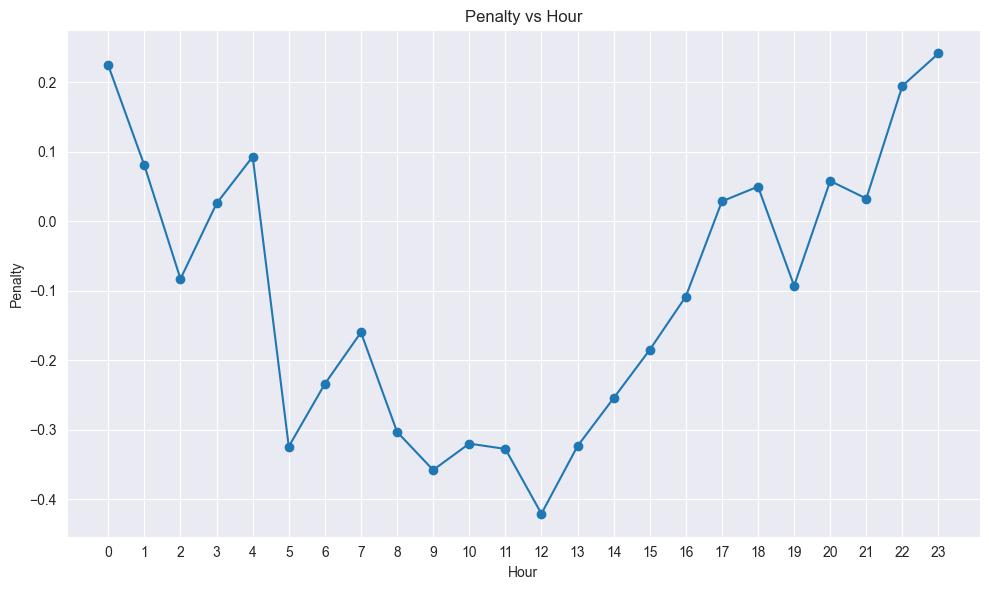

In [43]:
test = delta[(delta['month'] == 5) & (delta['week'] == 3) & (delta['lane'] == 3)]
plt.figure(figsize=(10, 6))
plt.plot(test['hour'], test['penalty'], marker='o', linestyle='-')
plt.title('Penalty vs Hour')
plt.xlabel('Hour')
plt.ylabel('Penalty')
plt.grid(True)
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()

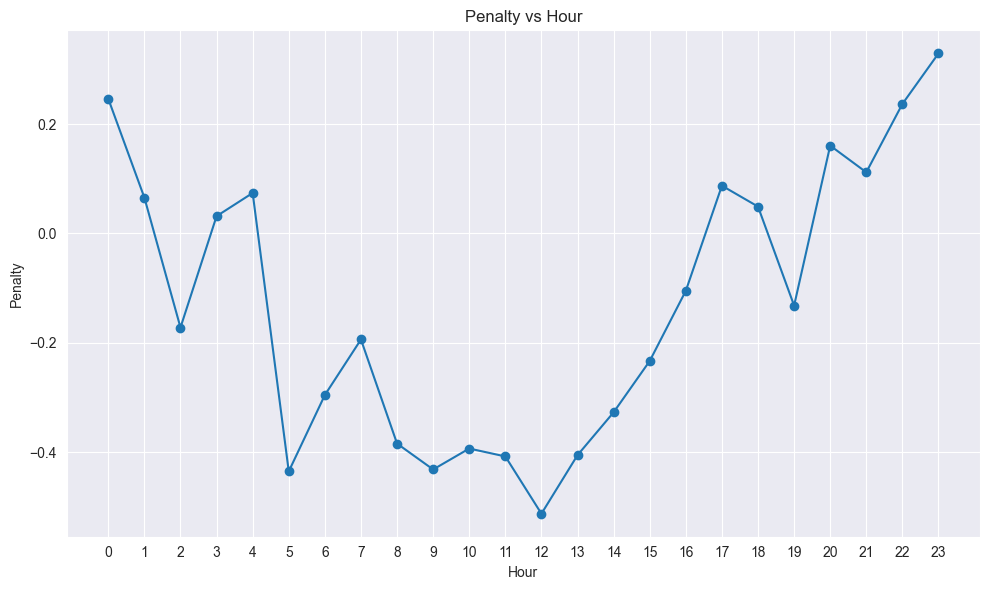

In [44]:
test = delta[(delta['month'] == 5) & (delta['week'] == 3) & (delta['lane'] == 4)]
plt.figure(figsize=(10, 6))
plt.plot(test['hour'], test['penalty'], marker='o', linestyle='-')
plt.title('Penalty vs Hour')
plt.xlabel('Hour')
plt.ylabel('Penalty')
plt.grid(True)
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()

## Apply Penalties to AvgSpeed

In [45]:
v_medie = pd.read_csv('./export_5t/export_polito_velocita_medie_feriali_nov2024.csv')
road = gpd.read_file('./export_5t/RR_SVR_intersezione_area_studio_Polito_ridotto.shp')

In [46]:
road

,idno,tail,head,leng,lane,geometry
0,892058820,65181913,929221967,49,1,"LINESTRING (7.68235 45.07484, 7.6829 45.07463)"
1,1202859687,65182218,1147089034,28,1,"LINESTRING (7.69595 45.06448, 7.6957 45.06466)"
2,55228101,65181859,65181853,69,1,"LINESTRING (7.68306 45.06943, 7.68279 45.06953..."
3,1202841601,1147078829,65172596,41,1,"LINESTRING (7.66934 45.05682, 7.66942 45.05676)"
4,55226323,65183722,65183726,16,1,"LINESTRING (7.68484 45.07632, 7.68492 45.07646)"
...,...,...,...,...,...,...
2574,824153093,880280494,65172902,9,1,"LINESTRING (7.67253 45.07389, 7.67264 45.07386)"
2575,822661236,65172276,879265696,34,3,"LINESTRING (7.66458 45.05886, 7.6642 45.05901)"
2576,55230058,65182077,65182075,84,1,"LINESTRING (7.69234 45.06079, 7.69179 45.06014)"
2577,1220137739,65174806,1158000085,31,3,"LINESTRING (7.67566 45.07921, 7.67602 45.07909)"


In [47]:
v_medie

,idno,tail,head,ora,vel_media
0,892058820,65181913,929221967,0,30
1,892058820,65181913,929221967,1,30
2,892058820,65181913,929221967,2,30
3,892058820,65181913,929221967,3,30
4,892058820,65181913,929221967,4,30
...,...,...,...,...,...
61891,55226373,65174777,65174776,19,29
61892,55226373,65174777,65174776,20,29
61893,55226373,65174777,65174776,21,29
61894,55226373,65174777,65174776,22,29


In [48]:
collection = (
    v_medie
    .merge(
    road[['idno', 'tail', 'head', 'leng', 'lane']], on=['idno', 'tail', 'head'], how='left')
    .rename(columns={'leng': 'length', 'idno': 'road_id', 'ora': 'hour', 'vel_media': 'avg_speed'})
)
print(collection)

         road_id      tail       head  hour  avg_speed  length  lane
0      892058820  65181913  929221967     0         30      49     1
1      892058820  65181913  929221967     1         30      49     1
2      892058820  65181913  929221967     2         30      49     1
3      892058820  65181913  929221967     3         30      49     1
4      892058820  65181913  929221967     4         30      49     1
...          ...       ...        ...   ...        ...     ...   ...
61891   55226373  65174777   65174776    19         29      16     1
61892   55226373  65174777   65174776    20         29      16     1
61893   55226373  65174777   65174776    21         29      16     1
61894   55226373  65174777   65174776    22         29      16     1
61895   55226373  65174777   65174776    23         29      16     1

[61896 rows x 7 columns]


In [49]:
summary_by_lane = (
    collection
    .groupby('lane')['avg_speed']
    .agg(['mean', 'std', 'max', 'min'])
    .reset_index()
)

print(summary_by_lane)

   lane       mean        std  max  min
0     1  27.228343   6.060847   49    0
1     2  30.078877   8.656881   49    5
2     3  31.373084   9.104329   56   11
3     4  30.416667  11.712883   49   16


In [50]:
# Mappa dei limiti di velocità per ciascun numero di corsie
speed_limits_by_lane = {
    1: 50,
    2: 50,
    3: 60,
    4: 70
}

# Applica la mappa al DataFrame
collection['speed_limit'] = collection['lane'].map(speed_limits_by_lane)
collection

,road_id,tail,head,hour,avg_speed,length,lane,speed_limit
0,892058820,65181913,929221967,0,30,49,1,50
1,892058820,65181913,929221967,1,30,49,1,50
2,892058820,65181913,929221967,2,30,49,1,50
3,892058820,65181913,929221967,3,30,49,1,50
4,892058820,65181913,929221967,4,30,49,1,50
...,...,...,...,...,...,...,...,...
61891,55226373,65174777,65174776,19,29,16,1,50
61892,55226373,65174777,65174776,20,29,16,1,50
61893,55226373,65174777,65174776,21,29,16,1,50
61894,55226373,65174777,65174776,22,29,16,1,50


In [51]:
print(len(collection[collection['avg_speed'] > collection['speed_limit']]))

0


In [52]:
print(collection)

         road_id      tail       head  hour  avg_speed  length  lane  \
0      892058820  65181913  929221967     0         30      49     1   
1      892058820  65181913  929221967     1         30      49     1   
2      892058820  65181913  929221967     2         30      49     1   
3      892058820  65181913  929221967     3         30      49     1   
4      892058820  65181913  929221967     4         30      49     1   
...          ...       ...        ...   ...        ...     ...   ...   
61891   55226373  65174777   65174776    19         29      16     1   
61892   55226373  65174777   65174776    20         29      16     1   
61893   55226373  65174777   65174776    21         29      16     1   
61894   55226373  65174777   65174776    22         29      16     1   
61895   55226373  65174777   65174776    23         29      16     1   

       speed_limit  
0               50  
1               50  
2               50  
3               50  
4               50  
...      

In [53]:
print(delta)

      lane  hour  week  month   penalty  seasonality
0        1     0     1      1  0.122840    -0.315136
1        1     0     1      2  0.135427    -0.308898
2        1     0     1      3  0.210578    -0.631397
3        1     0     1      4  0.205165    -0.630951
4        1     0     1      5  0.216009    -0.631843
...    ...   ...   ...    ...       ...          ...
8059     4    23     7      8 -0.096573    -0.616533
8060     4    23     7      9 -0.366498    -0.480164
8061     4    23     7     10 -0.016421    -0.417189
8062     4    23     7     11  0.080684    -0.346589
8063     4    23     7     12  0.015034    -0.047970

[8064 rows x 6 columns]


In [54]:
collection_ext = (
    collection
    .assign(key=1)
    .merge(pd.DataFrame([(w, m, 1) for w in list(range(1, 8)) for m in list(range(1, 13))], columns=['week', 'month', 'key']), on='key')
    .drop(columns='key')
)
collection_ext = collection_ext.merge(
    delta,
    on=['lane', 'hour', 'week', 'month'],
    how='left'
)
collection_ext['speed_clear'] = collection_ext['avg_speed'] * (1 + collection_ext['seasonality'])
collection_ext['speed_rain'] = collection_ext['speed_clear'] * (1 + collection_ext['penalty'])

# Limiti
min_speed = 5  # km/h
rain_limit_buffer = 5  # Penalità prudenziale in km/h

# Clipping superiore
collection_ext['speed_clear'] = np.minimum(collection_ext['speed_clear'], collection_ext['speed_limit'])
collection_ext['speed_rain'] = np.minimum(collection_ext['speed_rain'], collection_ext['speed_limit'] - rain_limit_buffer)

# Clipping inferiore
collection_ext['speed_clear'] = np.maximum(collection_ext['speed_clear'], min_speed)
collection_ext['speed_rain'] = np.maximum(collection_ext['speed_rain'], min_speed)

collection_ext.drop(columns=['penalty', 'seasonality', 'avg_speed', 'speed_limit'], inplace=True)

collection_ext

,road_id,tail,head,hour,length,lane,week,month,speed_clear,speed_rain
0,892058820,65181913,929221967,0,49,1,1,1,20.545919,23.069788
1,892058820,65181913,929221967,0,49,1,1,2,20.733059,23.540868
2,892058820,65181913,929221967,0,49,1,1,3,11.058086,13.386672
3,892058820,65181913,929221967,0,49,1,1,4,11.071480,13.342955
4,892058820,65181913,929221967,0,49,1,1,5,11.044705,13.430462
...,...,...,...,...,...,...,...,...,...,...
5199259,55226373,65174777,65174776,23,16,1,7,8,10.277823,11.356410
5199260,55226373,65174777,65174776,23,16,1,7,9,12.637001,9.056005
5199261,55226373,65174777,65174776,23,16,1,7,10,11.631617,6.159078
5199262,55226373,65174777,65174776,23,16,1,7,11,20.577132,27.223643


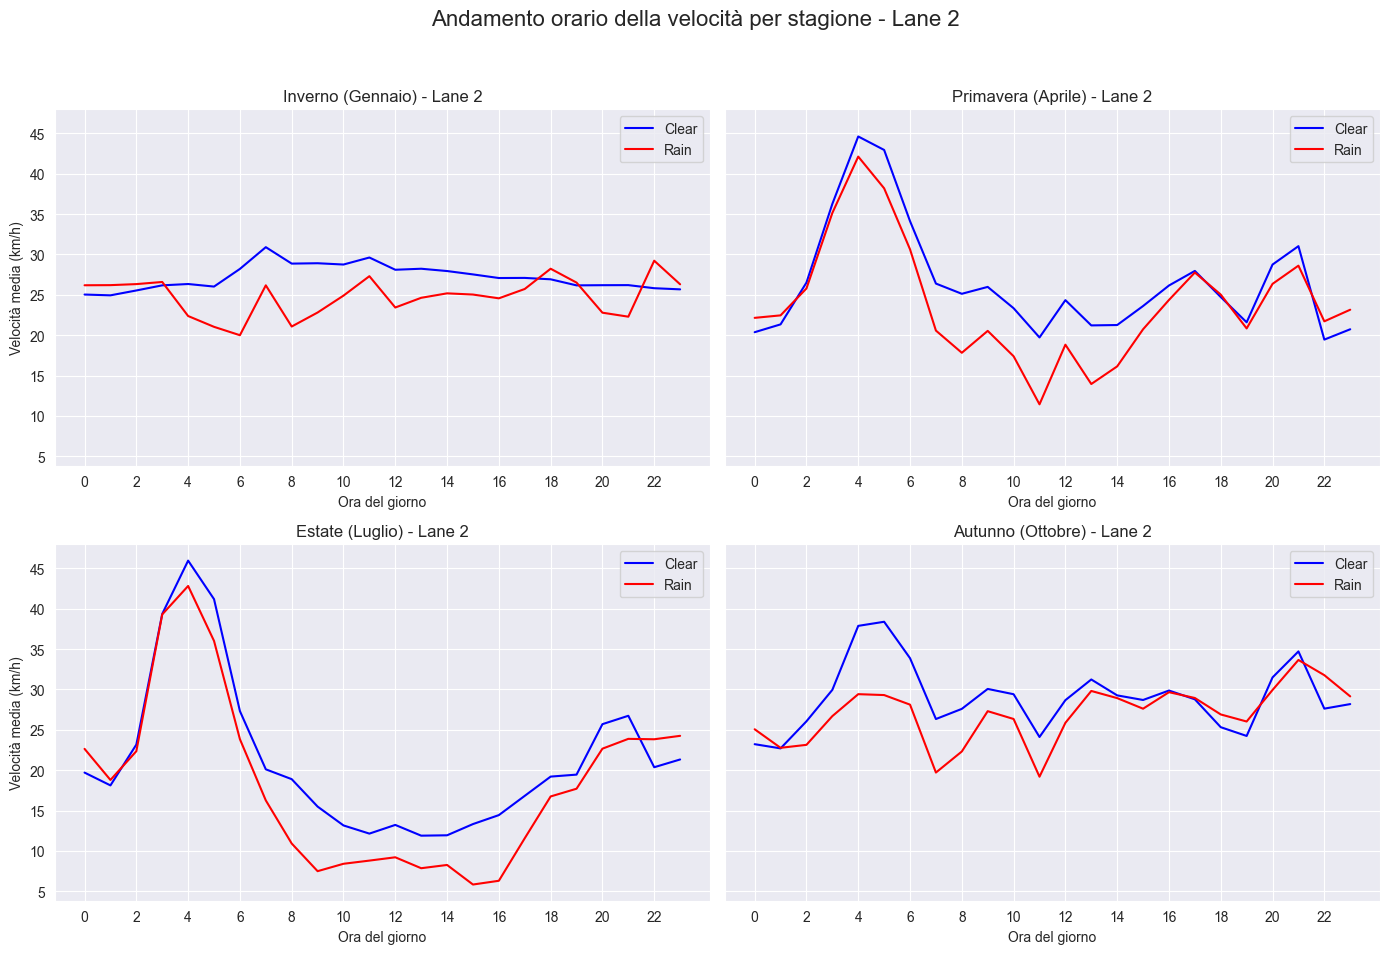

In [55]:
# Mesi rappresentativi delle stagioni
season_months = {
    'Inverno (Gennaio)': 1,
    'Primavera (Aprile)': 4,
    'Estate (Luglio)': 7,
    'Autunno (Ottobre)': 10
}

# Lane da visualizzare (puoi modificarlo per filtrare per una sola corsia)
lane_selected = 2  # oppure: per ognuna fai un grafico separato

# Prepara i dati aggregati
df_hourly = (
    collection_ext[collection_ext['lane'] == lane_selected]
    .groupby(['month', 'hour'])[['speed_clear', 'speed_rain']]
    .mean()
    .reset_index()
)

# Plot
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharey=True)
axes = axes.flatten()

for i, (season, month_num) in enumerate(season_months.items()):
    ax = axes[i]
    df_month = df_hourly[df_hourly['month'] == month_num]
    
    sns.lineplot(data=df_month, x='hour', y='speed_clear', ax=ax, label='Clear', color='blue')
    sns.lineplot(data=df_month, x='hour', y='speed_rain', ax=ax, label='Rain', color='red')
    
    ax.set_title(f'{season} - Lane {lane_selected}')
    ax.set_xlabel('Ora del giorno')
    ax.set_ylabel('Velocità media (km/h)')
    ax.set_xticks(range(0, 24, 2))
    ax.legend()

plt.suptitle(f'Andamento orario della velocità per stagione - Lane {lane_selected}', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [56]:
# Calcolo del tempo in secondi
collection_ext['time_clear'] = (collection_ext['length'] * 3.6) / collection_ext['speed_clear']
collection_ext['time_rain'] = (collection_ext['length'] * 3.6) / collection_ext['speed_rain']
collection_ext

,road_id,tail,head,hour,length,lane,week,month,speed_clear,speed_rain,time_clear,time_rain
0,892058820,65181913,929221967,0,49,1,1,1,20.545919,23.069788,8.585647,7.646364
1,892058820,65181913,929221967,0,49,1,1,2,20.733059,23.540868,8.508151,7.493352
2,892058820,65181913,929221967,0,49,1,1,3,11.058086,13.386672,15.952127,13.177286
3,892058820,65181913,929221967,0,49,1,1,4,11.071480,13.342955,15.932830,13.220460
4,892058820,65181913,929221967,0,49,1,1,5,11.044705,13.430462,15.971454,13.134321
...,...,...,...,...,...,...,...,...,...,...,...,...
5199259,55226373,65174777,65174776,23,16,1,7,8,10.277823,11.356410,5.604300,5.072026
5199260,55226373,65174777,65174776,23,16,1,7,9,12.637001,9.056005,4.558043,6.360421
5199261,55226373,65174777,65174776,23,16,1,7,10,11.631617,6.159078,4.952020,9.352048
5199262,55226373,65174777,65174776,23,16,1,7,11,20.577132,27.223643,2.799224,2.115808


In [57]:
# NOW
percentiles = [0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]

summary_percentiles = (
    collection_ext
    .groupby('lane')[['speed_clear', 'speed_rain']]
    .quantile(percentiles)
    .unstack(level=-1)
    .round(2)
)

summary_stats = (
    collection_ext
    .groupby('lane')[['speed_clear', 'speed_rain']]
    .agg(['mean', 'std', 'min', 'max'])
    .round(2)
)

summary_full = pd.concat([summary_stats, summary_percentiles], axis=1)
print(summary_full.T)

lane                  1      2      3      4
speed_clear mean  26.30  26.18  26.74  25.48
            std   11.19  11.82  13.79  16.07
            min    5.00   5.00   5.00   5.00
            max   50.00  50.00  60.00  70.00
speed_rain  mean  26.04  23.88  24.26  23.19
            std   10.97  12.05  14.78  16.84
            min    5.00   5.00   5.00   5.00
            max   45.00  45.00  55.00  65.00
speed_clear 0.01   5.00   6.04   5.00   5.00
            0.05   9.36   9.60   7.80   5.04
            0.25  18.25  16.57  15.77  13.24
            0.5   25.97  25.04  24.76  21.53
            0.75  31.94  33.64  35.64  33.95
            0.95  50.00  50.00  54.38  58.36
            0.99  50.00  50.00  60.00  70.00
speed_rain  0.01   5.00   5.00   5.00   5.00
            0.05   8.63   5.99   5.00   5.00
            0.25  17.99  13.88  11.82   9.11
            0.5   25.48  22.79  22.14  19.01
            0.75  33.19  32.42  34.07  32.68
            0.95  45.00  45.00  55.00  61.44
          

In [58]:
avg_speed_percentiles = (
    collection
    .groupby('lane')['avg_speed']
    .quantile(percentiles)
    .unstack(level=-1)
    .round(2)
)

avg_speed_stats = (
    collection
    .groupby('lane')['avg_speed']
    .agg(['mean', 'std', 'min', 'max'])
    .round(2)
)

avg_speed_full = pd.concat([avg_speed_stats, avg_speed_percentiles], axis=1)
print(avg_speed_full.T)

lane      1      2      3      4
mean  27.23  30.08  31.37  30.42
std    6.06   8.66   9.10  11.71
min    0.00   5.00  11.00  16.00
max   49.00  49.00  56.00  49.00
0.01   1.00  12.00  12.00  17.00
0.05  14.00  14.00  14.00  18.00
0.25  26.00  26.00  24.00  21.00
0.5   29.00  29.00  31.00  26.50
0.75  30.00  35.00  38.00  43.00
0.95  35.00  47.00  47.00  49.00
0.99  42.00  49.00  52.00  49.00


In [60]:
time = collection_ext[['time_clear', 'time_rain']]
time.describe()

,time_clear,time_rain
count,5.199264e+06,5.199264e+06
mean,8.922148e+00,9.767994e+00
std,9.831249e+00,1.136022e+01
min,1.440000e-01,1.600000e-01
25%,2.880642e+00,3.023221e+00
50%,6.064560e+00,6.416479e+00
75%,1.138761e+01,1.213759e+01
max,1.533600e+02,1.692000e+02


# NOW UPLOAD 'collection_ext' TO MONGO DB AS A NEW COLLECTION (traffic_full)

## OR MAYBE JOIN DIRECTLY TO ROAD? (AND USE ONLY ONE COLLECTION) --> ASK TO WENXI